# 1. Imports

In [2]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 2. Importing images and converting to NumPy Array

In [4]:
labels = ['PNEUMONIA','NORMAL']
IMG_SIZE = 100

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir,label)
        class_to_index = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                resized_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                data.append([resized_array,class_to_index])
            except Exception as e:
                print(e)
    return np.array(data)


# 3. Loading Data

In [5]:
train_data = get_data('dataset/train') 
test_data = get_data('dataset/test')
val_data = get_data('dataset/val')

C:\Users\niyar\AppData\Local\Temp\ipykernel_5212\2201399876.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [6]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []


for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)

In [7]:
# Normalise

x_train = np.array(x_train)/255
x_test = np.array(x_test)/255
x_val = np.array(x_val)/255

In [8]:
# Resizing

x_train = x_train.reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1,IMG_SIZE,IMG_SIZE,1)
y_val = np.array(y_val)

In [9]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

# 4. Data Augmentation

In [10]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            rotation_range=30,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=False,
                            width_shift_range=0.2,
                            height_shift_range=0.2)

datagen.fit(x_train)

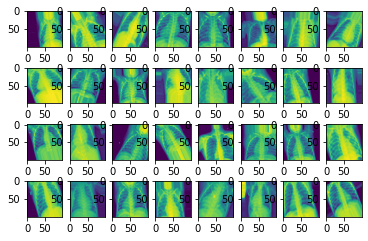

In [11]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

# 5. Creating & Training Model 

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides = 1, activation="relu", input_shape = (100, 100, 1), padding = "same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides = 1, activation="relu", input_shape = (100, 100, 1), padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = "same"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(units=1024, activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 50, 50, 64)      

In [15]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=tf.losses.BinaryCrossentropy(),
             optimizer = opt,
             metrics = ["accuracy"])

In [17]:
model.fit(datagen.flow(x_train,y_train, batch_size=32),
          epochs = 10 ,
          validation_data=datagen.flow(x_val, y_val))

Epoch 1/10
84/84 [==============================] - 28s 324ms/step - loss: 0.4165 - accuracy: 0.8091 - val_loss: 0.9364 - val_accuracy: 0.5000
Epoch 2/10
84/84 [==============================] - 28s 329ms/step - loss: 0.3246 - accuracy: 0.8719 - val_loss: 1.7791 - val_accuracy: 0.5000
Epoch 3/10
84/84 [==============================] - 28s 332ms/step - loss: 0.2746 - accuracy: 0.8920 - val_loss: 2.6174 - val_accuracy: 0.5000
Epoch 4/10
84/84 [==============================] - 27s 317ms/step - loss: 0.2610 - accuracy: 0.8958 - val_loss: 3.3487 - val_accuracy: 0.5000
Epoch 5/10
84/84 [==============================] - 27s 318ms/step - loss: 0.2557 - accuracy: 0.8976 - val_loss: 3.4439 - val_accuracy: 0.5000
Epoch 6/10
84/84 [==============================] - 27s 318ms/step - loss: 0.2391 - accuracy: 0.9044 - val_loss: 3.1966 - val_accuracy: 0.5000
Epoch 7/10
84/84 [==============================] - 27s 317ms/step - loss: 0.2332 - accuracy: 0.9077 - val_loss: 2.3682 - val_accuracy: 0.5000

# 6. Evaluation and Prediction

In [18]:
eval = model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 59ms/step - loss: 0.2834 - accuracy: 0.8958


In [19]:
print(f"Testing Accuracy of the Model is {eval[1]*100}%")

Testing Accuracy of the Model is 89.58333134651184%


In [20]:
def predict(path):
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    resized_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    image = np.array(resized_array)/255
    plt.imshow(image,cmap = 'gray')
    image = image.reshape(1,IMG_SIZE,IMG_SIZE,1)
    prediction = model.predict(image)
    print(prediction)
    if prediction > 0.5:
        print("NORMAL")
    else:
        print("PNEUMONIA")

1/1 [==============================] - 0s 116ms/step
[[0.12388317]]
PNEUMONIA


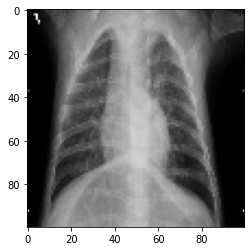

In [21]:
path = "dataset/test/PNEUMONIA/person1660_virus_2869.jpeg"

predict(path)
